<a href="https://colab.research.google.com/github/vidyasrigr/Perfume-Recommender/blob/master/perfume_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models import word2vec
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import json
import os

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df=pd.read_csv("/content/perfume_data.csv")
print(df.shape)

df['Fragrance'] = df['Fragrance'].str.lower()
df["Overview"] = df["Overview"].str.lower()
df['Top'] = df['Top'].str.lower()
df['Heart'] = df['Heart'].str.lower()
df['Base'] = df['Base'].str.lower()
#show 10 lines of the new dataframe
print (df.shape)
print(df.head)

(1008, 15)
(1008, 15)
<bound method NDFrame.head of       INDEX  Gender                 Brand       Fragrance  \
0         1  Unisex             Sean John         3:00 am   
1         2  Unisex     Comme des Garçons               2   
2         3   Women      Carolina Herrera             212   
3         4     Men  Histoires de Parfums            1725   
4         5     Men  Histoires de Parfums            1740   
...     ...     ...                   ...             ...   
1003   1004   Women               Versace  yellow diamond   
1004   1005   Women          Estée Lauder       youth dew   
1005   1006   Women              Givenchy          ysatis   
1006   1007     Men          Parfums MDCI      yuzu rouge   
1007   1008  Unisex          Parfums MDCI      yuzu rouge   

                                Top                                    Heart  \
0      mandarin, bergamot, cardamom      tangerine, orange blossom, geranium   
1          aldehydes, mandarin, tea               nutme

In [3]:
df=df.dropna()
df

,INDEX,Gender,Brand,Fragrance,Top,Heart,Base,Description,Longevity,Seasonal Use,Occasion,Projection/Sillage,Price,Rating,Overview
0,1,Unisex,Sean John,3:00 am,"mandarin, bergamot, cardamom","tangerine, orange blossom, geranium","fig leaves, smoky suede, leather",A spicy and aromatic fragrance that captures t...,Moderate,Fall & Winter,Casual (Daytime),Moderate,Expensive,4.5,"unisex,sean john,0.125,mandarin, bergamot, car..."
1,2,Unisex,Comme des Garçons,2,"aldehydes, mandarin, tea","nutmeg, mate, ink, incense","vetiver, cedarwood, white musk, patchouli",A complex fragrance with a smoky and woody pro...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.1,"unisex,comme des garçons,2,aldehydes, mandarin..."
2,3,Women,Carolina Herrera,212,"orange blossom, mandarin","gardenia, camellia","sandalwood, white musk","A floral woody musk fragrance, with a modern a...",Moderate to long-lasting,Spring & Fall,Formal (Daytime),Moderate,Expensive,4.4,"women,carolina herrera,212,orange blossom, man..."
3,4,Men,Histoires de Parfums,1725,"bergamot, citrus, grapefruit","jasmine, violet, geranium","vanilla, white musk, amber",A fresh and citrusy scent inspired by the Fren...,Long-lasting,Fall & Winter,Formal (Evening),Moderate to Heavy,Exorbitant,4.1,"men,histoires de parfums,1725,bergamot, citrus..."
4,5,Men,Histoires de Parfums,1740,"bergamot, davana, birch tar","patchouli, cedar, lavender, vanilla","leather, amber, vanilla, immortelle",A spicy and smoky fragrance for men that is in...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.1,"men,histoires de parfums,1740,bergamot, davana..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1004,Women,Versace,yellow diamond,"citron, pear sorbet, bergamot","neroli, orange blossom, freesia, mimosa","amber, palomino, musk",A fresh and floral fragrance that captures the...,Moderate,Spring & Summer,Casual (Daytime),Moderate,Expensive,4.6,"women,versace,yellow diamond,citron, pear sorb..."
1004,1005,Women,Estée Lauder,youth dew,"rose, jonquil, lavender","jasmine, muguet, spices","moss, vetiver, patchouli",A spicy oriental fragrance that is perfect for...,Long-lasting,Fall & Winter,Formal (All),Heavy,Exorbitant,4.3,"women,estée lauder,youth dew,rose, jonquil, la..."
1005,1006,Women,Givenchy,ysatis,"mandarin, galbanum, rose","jasmine, iris, tuberose","amber, vanilla, vetiver",Ysatis is a classic and timeless fragrance tha...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.5,"women,givenchy,ysatis,mandarin, galbanum, rose..."
1006,1007,Men,Parfums MDCI,yuzu rouge,"yuzu, red pepper, grapefruit","jasmine, marine notes, hedione","vetiver, musk, woody notes","A fresh, aquatic fragrance with citrusy and sp...",Moderate,Spring & Summer,Casual (All),Moderate,Expensive,4.2,"men,parfums mdci,yuzu rouge,yuzu, red pepper, ..."


In [4]:
counts = df['Gender'].value_counts()
count_percent = df['Gender'].value_counts(1)*100
counts_df = pd.DataFrame({'Target Gender':counts.index,'Perfume Count':counts.values,'Percent':np.round(count_percent.values,2)})
display(counts_df)

,Target Gender,Perfume Count,Percent
0,Women,498,49.90
1,Men,321,32.16
2,Unisex,179,17.94


In [5]:
px.bar(data_frame=counts_df,
       x='Target Gender',
       y='Perfume Count',
       color='Percent',
       color_continuous_scale='blues',
       text_auto=True,
       title=f'Number of Perfumes in each Gender',
       width=800, height=400)

In [6]:
counts = df['Brand'].value_counts()
count_percent = df['Brand'].value_counts(1)*100
counts_df = pd.DataFrame({'Brand':counts.index,'Perfume Count':counts.values,'Percent':np.round(count_percent.values,2)})
display(counts_df)

,Brand,Perfume Count,Percent
0,Tom Ford,38,3.81
1,Atelier Cologne,31,3.11
2,Hermes,29,2.91
3,Versace,23,2.30
4,Prada,23,2.30
...,...,...,...
161,Profumum Roma,1,0.10
162,Parfums DelRae,1,0.10
163,Miller Harris,1,0.10
164,LVNEA,1,0.10


In [7]:
px.bar(data_frame=counts_df[:15],
       x='Brand',
       y='Perfume Count',
       color='Percent',
       color_continuous_scale='blues',
       text_auto=True,
       title=f'Brands with the most number of perfumes',
       width=800, height=400)

In [9]:
stop = set(stopwords.words('english'))
stop |= set([',','&','a','notes','note','of','with','and', 'is', 'both', 'fragrance', 'feeling', 'inspired', 'perfect', 'mix', 'energy',
             'essence', 'unique', 'uniquely', 'stand', 'out', 'for', 'that', 'those'])
lemmatizer = WordNetLemmatizer()

In [10]:
def data_preprocessing(text):
    if not isinstance(text, str):
        return ''
    text = re.sub("[!@#$+%*:()/<.=—']", ' ', text)
    text = text.replace(',', ' ')
    text = text.replace('  ', ' ')
    text = ' '.join([word for word in text.split() if word not in stop])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [11]:
df['Fragrance'] = df['Fragrance'].apply(lambda x: data_preprocessing(x))
df['Overview'] = df['Overview'].apply(lambda x: data_preprocessing(x))
df['Top'] = df['Top'].apply(lambda x: data_preprocessing(x))
df['Heart'] = df['Heart'].apply(lambda x: data_preprocessing(x))
df['Base'] = df['Base'].apply(lambda x: data_preprocessing(x))

In [12]:
df.reset_index()

,index,INDEX,Gender,Brand,Fragrance,Top,Heart,Base,Description,Longevity,Seasonal Use,Occasion,Projection/Sillage,Price,Rating,Overview
0,0,1,Unisex,Sean John,3 00,mandarin bergamot cardamom,tangerine orange blossom geranium,fig leaf smoky suede leather,A spicy and aromatic fragrance that captures t...,Moderate,Fall & Winter,Casual (Daytime),Moderate,Expensive,4.5,unisex sean john 0 125 mandarin bergamot carda...
1,1,2,Unisex,Comme des Garçons,2,aldehyde mandarin tea,nutmeg mate ink incense,vetiver cedarwood white musk patchouli,A complex fragrance with a smoky and woody pro...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.1,unisex comme de garçons 2 aldehyde mandarin te...
2,2,3,Women,Carolina Herrera,212,orange blossom mandarin,gardenia camellia,sandalwood white musk,"A floral woody musk fragrance, with a modern a...",Moderate to long-lasting,Spring & Fall,Formal (Daytime),Moderate,Expensive,4.4,woman carolina herrera 212 orange blossom mand...
3,3,4,Men,Histoires de Parfums,1725,bergamot citrus grapefruit,jasmine violet geranium,vanilla white musk amber,A fresh and citrusy scent inspired by the Fren...,Long-lasting,Fall & Winter,Formal (Evening),Moderate to Heavy,Exorbitant,4.1,men histoires de parfums 1725 bergamot citrus ...
4,4,5,Men,Histoires de Parfums,1740,bergamot davana birch tar,patchouli cedar lavender vanilla,leather amber vanilla immortelle,A spicy and smoky fragrance for men that is in...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.1,men histoires de parfums 1740 bergamot davana ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1003,1004,Women,Versace,yellow diamond,citron pear sorbet bergamot,neroli orange blossom freesia mimosa,amber palomino musk,A fresh and floral fragrance that captures the...,Moderate,Spring & Summer,Casual (Daytime),Moderate,Expensive,4.6,woman versace yellow diamond citron pear sorbe...
994,1004,1005,Women,Estée Lauder,youth dew,rose jonquil lavender,jasmine muguet spice,moss vetiver patchouli,A spicy oriental fragrance that is perfect for...,Long-lasting,Fall & Winter,Formal (All),Heavy,Exorbitant,4.3,woman estée lauder youth dew rose jonquil lave...
995,1005,1006,Women,Givenchy,ysatis,mandarin galbanum rose,jasmine iris tuberose,amber vanilla vetiver,Ysatis is a classic and timeless fragrance tha...,Long-lasting,Fall & Winter,Formal (Evening),Heavy,Exorbitant,4.5,woman givenchy ysatis mandarin galbanum rose j...
996,1006,1007,Men,Parfums MDCI,yuzu rouge,yuzu red pepper grapefruit,jasmine marine hedione,vetiver musk woody,"A fresh, aquatic fragrance with citrusy and sp...",Moderate,Spring & Summer,Casual (All),Moderate,Expensive,4.2,men parfums mdci yuzu rouge yuzu red pepper gr...


Text(0.5, 1.0, 'Figure 1. Overview Corpus Word Cloud')

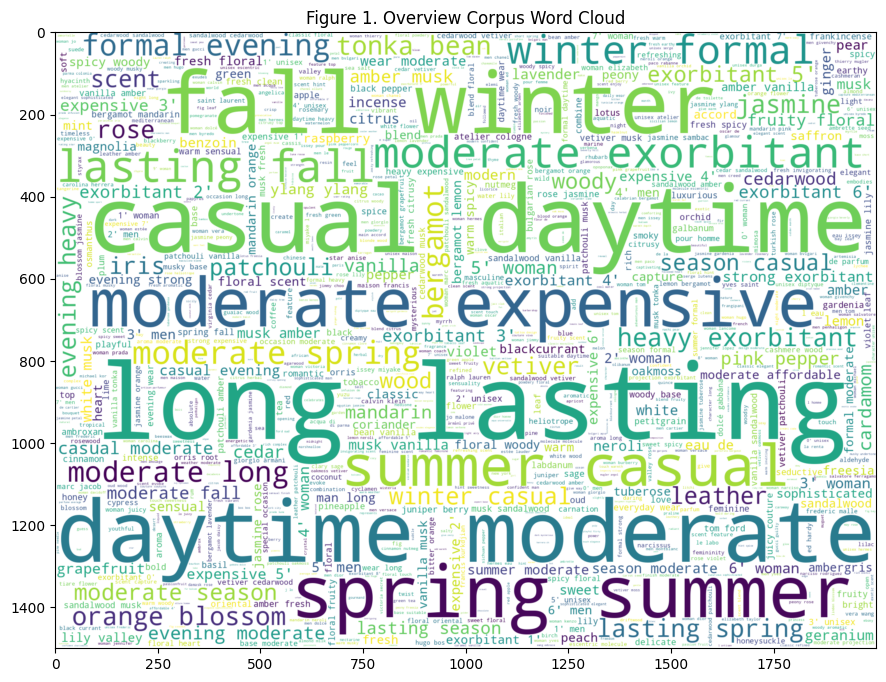

In [13]:
contentCorpus = df.Overview.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 2000,height = 1500,background_color="white",max_words=1000).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 1. Overview Corpus Word Cloud')

Text(0.5, 1.0, 'Figure 2. Top Corpus Word Cloud')

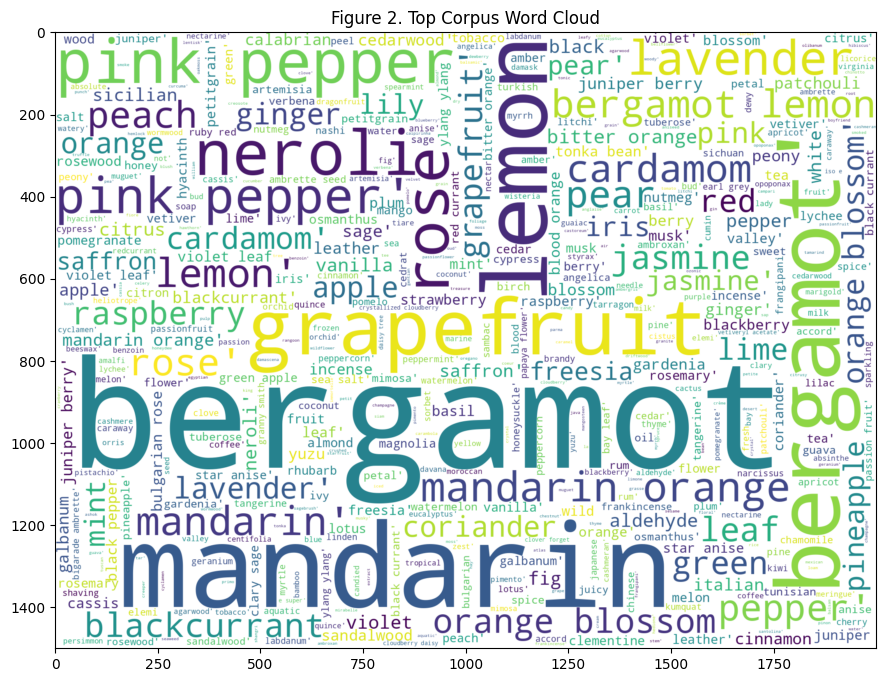

In [14]:
contentCorpus = df.Top.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 2000,height = 1500,background_color="white",max_words=500).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 2. Top Corpus Word Cloud')

Text(0.5, 1.0, 'Figure 2. Top Corpus Word Cloud')

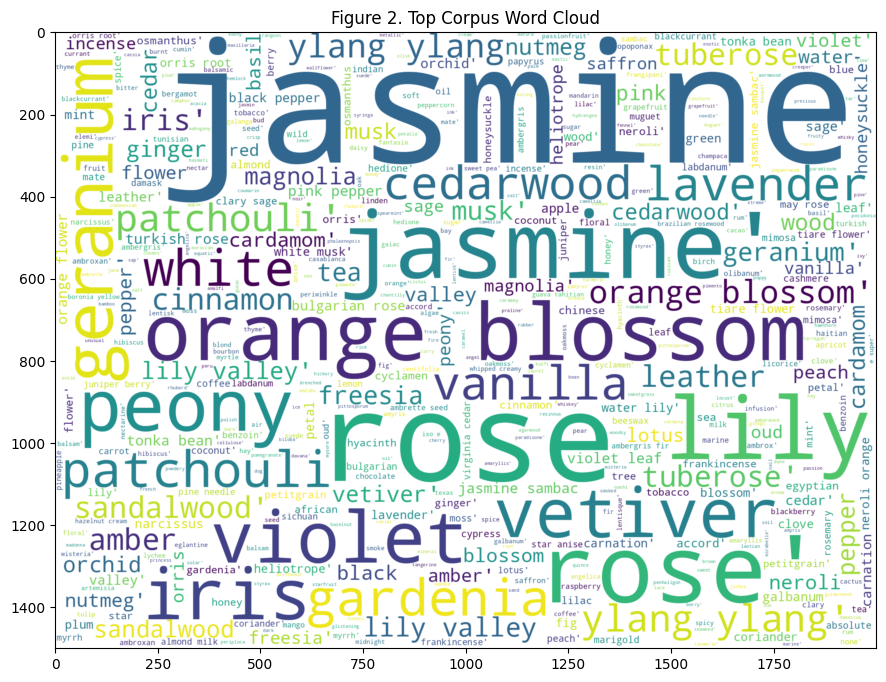

In [15]:
contentCorpus = df.Heart.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 2000,height = 1500,background_color="white",max_words=500).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 2. Top Corpus Word Cloud')

Text(0.5, 1.0, 'Figure 2. Top Corpus Word Cloud')

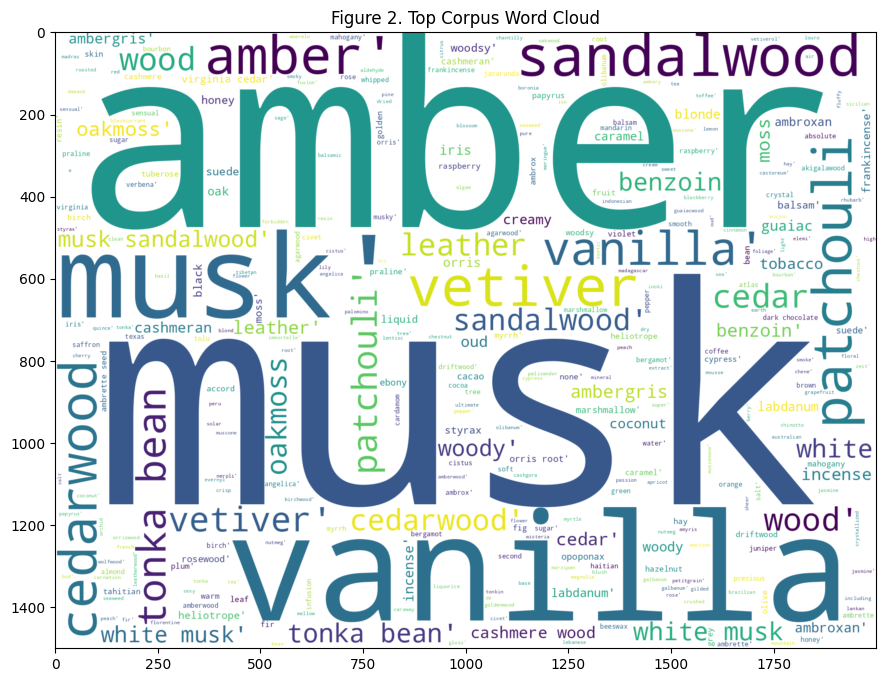

In [16]:
contentCorpus = df.Base.values
plt.figure(figsize = (12, 8))
wordcloud = WordCloud(width = 2000,height = 1500,background_color="white",max_words=500).generate(str(contentCorpus))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Figure 2. Top Corpus Word Cloud')

**Model Selection and Fitting Data**

In [17]:
tokenized_sentences_fragrance = [sentence.split() for sentence in df['Fragrance'].values]
tokenized_sentences_overview = [sentence.split() for sentence in df['Overview'].values]
tokenized_sentences_top = [sentence.split() for sentence in df['Top'].values]
tokenized_sentences_heart = [sentence.split() for sentence in df['Heart'].values]
tokenized_sentences_base = [sentence.split() for sentence in df['Base'].values]

In [18]:
df['fragrance_tokenized'] = tokenized_sentences_fragrance
df['overview_tokenized'] = tokenized_sentences_overview
df['top_tokenized'] = tokenized_sentences_top
df['heart_tokenized'] = tokenized_sentences_heart
df['base_tokenized'] = tokenized_sentences_base

In [19]:
# Abstract = Overview
model = word2vec.Word2Vec(tokenized_sentences_base, vector_size = 100, min_count=1)

In [20]:
def buildWordVector(word_list, size):
    #function to average all words vectors in a given paragraph
    vec = np.zeros(size)
    count = 0.
    for word in word_list:
        if word in model.wv:
            vec += model.wv[word]
            count += 1.
    if count != 0:
        vec /= count
    return vec

In [21]:
df['fragrance_embedding'] = df['fragrance_tokenized'].apply(lambda x: buildWordVector(x, size = 100))
df['overview_embedding'] = df['overview_tokenized'].apply(lambda x: buildWordVector(x, size = 100))
df['top_embedding'] = df['top_tokenized'].apply(lambda x: buildWordVector(x, size = 100))
df['heart_embedding'] = df['heart_tokenized'].apply(lambda x: buildWordVector(x, size = 100))
df['base_embedding'] = df['base_tokenized'].apply(lambda x: buildWordVector(x, size = 100))

In [22]:
df.head(2)

,INDEX,Gender,Brand,Fragrance,Top,Heart,Base,Description,Longevity,Seasonal Use,...,fragrance_tokenized,overview_tokenized,top_tokenized,heart_tokenized,base_tokenized,fragrance_embedding,overview_embedding,top_embedding,heart_embedding,base_embedding
0,1,Unisex,Sean John,3 00,mandarin bergamot cardamom,tangerine orange blossom geranium,fig leaf smoky suede leather,A spicy and aromatic fragrance that captures t...,Moderate,Fall & Winter,...,"[3, 00]","[unisex, sean, john, 0, 125, mandarin, bergamo...","[mandarin, bergamot, cardamom]","[tangerine, orange, blossom, geranium]","[fig, leaf, smoky, suede, leather]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.002786064043175429, -0.0015942815458402037...","[-0.006065774165714781, -0.002412162721157074,...","[-0.0005109249614179134, -0.001109887612983584...","[-0.0017282936023548245, -0.001297310413792729..."
1,2,Unisex,Comme des Garçons,2,aldehyde mandarin tea,nutmeg mate ink incense,vetiver cedarwood white musk patchouli,A complex fragrance with a smoky and woody pro...,Long-lasting,Fall & Winter,...,[2],"[unisex, comme, de, garçons, 2, aldehyde, mand...","[aldehyde, mandarin, tea]","[nutmeg, mate, ink, incense]","[vetiver, cedarwood, white, musk, patchouli]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.002499683565334775, 0.0011270734696434094,...","[-0.0030982154421508312, -0.004514446365647018...","[0.0025132652808679268, 0.0008644869085401297,...","[-0.0033706380985677243, 0.003281107428483665,..."


In [23]:
def embedding_query(query):
    query = query.split(' ')
    query_vec = np.zeros(100).reshape((1,100))
    count = 0
    for word in query:
        if word in model.wv:
            query_vec += model.wv[word]
            count += 1.
    if count != 0:
        query_vec /= count
    return query_vec

In [24]:
def get_similarity(fragrance_input, top_input, heart_input, base_input, n_top):
    top_vec = embedding_query(top_input)
    heart_vec = embedding_query(heart_input)
    base_vec = embedding_query(base_input)

    df["cos_sim_top"] = df['top_embedding'].apply(
        lambda x: metrics.pairwise.cosine_similarity(
            [x], top_vec.reshape(1,-1))[0][0])
    df["cos_sim_heart"] = df['heart_embedding'].apply(
        lambda x: metrics.pairwise.cosine_similarity(
            [x], heart_vec.reshape(1,-1))[0][0])
    df["cos_sim_base"] = df['base_embedding'].apply(
        lambda x: metrics.pairwise.cosine_similarity(
            [x], base_vec.reshape(1,-1))[0][0])

    df["cos_sim"] = (df["cos_sim_top"] + df["cos_sim_heart"] + df["cos_sim_base"]) / 3
    recommendation_list = (df.sort_values("cos_sim", ascending=False)
                [["Fragrance","Top","Heart","Base","cos_sim"]]
                .drop_duplicates()[:n_top])

    # return recommendation_list[:n_top]

    # Filter out the input fragrance from the recommendation list
    recommendation_list = recommendation_list[recommendation_list['Fragrance'] != fragrance_input]

    # Add Brand and Description columns to the recommendation_list
    recommendation_list['Brand'] = recommendation_list['Fragrance'].apply(lambda x: df.loc[df['Fragrance'] == x, 'Brand'].values[0])
    recommendation_list['Description'] = recommendation_list['Fragrance'].apply(lambda x: df.loc[df['Fragrance'] == x, 'Description'].values[0])

    recommendation_list = recommendation_list[['Brand', 'Fragrance', 'Description', 'cos_sim']]
    # Return the complete recommendation list
    return recommendation_list

In [25]:
def get_inputs(fragrance_input, n_top):
    row = df.loc[df['Fragrance'] == fragrance_input]

    # Extract the values of the Top and Base features
    top_input = row['Top'].values[0]
    heart_input = row['Heart'].values[0]
    base_input = row['Base'].values[0]

    recommendation_list = get_similarity(fragrance_input, top_input, heart_input, base_input, n_top)

    for i, row in enumerate(recommendation_list.iterrows(), start=1):
        brand_name = row[1]['Brand']
        fragrance_name = row[1]['Fragrance']
        description = row[1]['Description']
        similarity = row[1]['cos_sim']
        print(f"Recommendation #{i}. {brand_name} - {fragrance_name}. {description} This is {similarity:.2%} similar to the fragrance you chose.")

In [27]:
get_inputs('one', 4)

Recommendation #1. Jean Patou - eau de patou. A classic and timeless fragrance that exudes refinement and elegance This is 92.84% similar to the fragrance you chose.
Recommendation #2. Carthusia - capri forget. A fresh, citrusy fragrance with a hint of mint This is 92.17% similar to the fragrance you chose.
Recommendation #3. Chanel - cristalle. A fresh and vibrant scent with a citrusy top note, a floral heart, and a mossy, earthy base. It is a youthful and modern fragrance that is perfect for spring and summer. This is 91.09% similar to the fragrance you chose.
